# **🧬 Automated Detection of Bacterial Flagellar Motors in Cryo-Electron Tomograms**

## **Background**
The **flagellar motor** is a remarkable molecular machine responsible for the motility of many microorganisms. It plays a critical role in biological processes such as **chemotaxis** (movement in response to chemical stimuli) and **pathogenesis** (the development of disease).

## **Imaging with Cryo-Electron Tomography (Cryo-ET)**
**Cryogenic electron tomography (cryo-ET)** is a powerful imaging technique that enables visualization of cellular structures in near-native conditions. It reconstructs 3D images (tomograms) from a series of 2D projections, providing detailed views of intracellular components like the flagellar motor.

## **Challenge**
Despite its capabilities, cryo-ET presents several challenges for automated analysis:
- **Low signal-to-noise ratio**
- **Variable orientations** of the flagellar motor
- **Complex and crowded intracellular environments**

These factors make manual annotation necessary, creating a **bottleneck** in the analysis pipeline and limiting scalability.

## **Objective**
The goal of this task is to develop an **image processing algorithm** that can:
- Automatically identify the **presence and location** of a flagellar motor within a tomogram.
- Reduce reliance on manual intervention and improve processing efficiency.

## **About the Data**
- Each **tomogram** is a 3D reconstruction created from multiple 2D electron microscopy images.
- The bacterial samples were **flash-frozen** in ice to preserve their native molecular structures.

---

# **This is part 1 of the notebook focusing on data preprocessing**

In [6]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import yaml
import random
import matplotlib.pyplot as plt
import json

np.random.seed(42)

## **Initializing Project**

In [3]:
# Define Kaggle paths
data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
train_dir = os.path.join(data_path, "train")

# Define YOLO dataset structure
yolo_dataset_dir = "/kaggle/working/yolo_dataset"
yolo_images_train = os.path.join(yolo_dataset_dir, "images", "train")
yolo_images_val = os.path.join(yolo_dataset_dir, "images", "val")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "val")

# Create directories
for dir_path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    os.makedirs(dir_path, exist_ok=True)

# Define constants
TRUST = 4  # Number of slices above and below center slice (total 2*TRUST + 1 slices)
BOX_SIZE = 24  # Bounding box size for annotations (in pixels)
TRAIN_SPLIT = 0.8  # 80% for training, 20% for validation


## **Data Inspection**

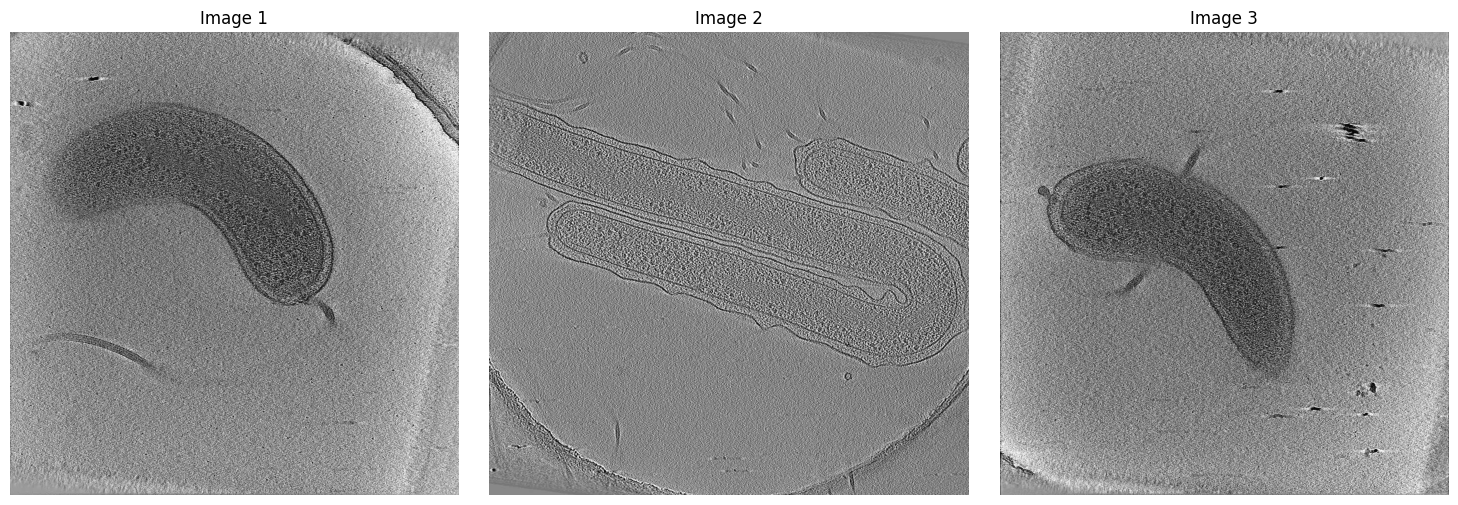

In [11]:
sample_images = [
    "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/tomo_00e047/slice_0169.jpg",
    "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/tomo_00e463/slice_0235.jpg",
    "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/tomo_02862f/slice_0101.jpg"
]

num_images = len(sample_images)

plt.figure(figsize=(15, 5))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

### **Percentile Contrast Stretching or Percentile Normalization**

- Function : `normalize_slice`
- It enhances image contrast by focusing on the central distribution of pixel values.
- The 2nd and 98th percentiles help exclude extreme low and high intensity values (which may be noise or artifacts).
- It’s especially useful for microscopy and tomography, where lighting or density variations can make raw images hard to interpret.

In [3]:
def normalize_slice(slice_data):
    """
    Normalize slice data using 2nd and 98th percentiles
    """
    # Calculate percentiles
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    
    # Clip the data to the percentile range
    clipped_data = np.clip(slice_data, p2, p98)
    
    # Normalize to [0, 255] range
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    
    return np.uint8(normalized)

### **Function: `prepare_yolo_dataset`**

Prepare **YOLO-based object detection** by extracting and processing image slices from tomograms.

#### **What it does:**

- **Reads motor location annotations** from a CSV file (`train_labels.csv`) which includes the 3D coordinates of motors in tomograms.
- **Filters tomograms** to only those that contain motors.
- **Performs a train-validation split** at the tomogram level, ensuring that all slices from a single tomogram belong to the same split (to avoid data leakage).
- For each motor:
  - **Extracts a local region of slices** around the motor center along the z-axis (±`trust` slices).
  - **Normalizes** each extracted 2D slice using percentile contrast stretching (see `normalize_slice`).
  - **Saves the image** in JPEG format with a filename that encodes spatial information.
  - **Generates YOLO-format annotation files** specifying the motor’s 2D position and bounding box within each slice.

#### **YOLO Format Annotations:**
Each annotation file contains a single line:
```
<class_id> <x_center> <y_center> <width> <height>
```
All coordinates are normalized to `[0, 1]` relative to the image dimensions.

#### **Output:**
- A structured dataset with images and labels stored in:
  - `images/train` and `labels/train`
  - `images/val` and `labels/val`
- A `dataset.yaml` file that configures the YOLO training environment.
- A printed summary of the number of tomograms, motors, and slices used in the train and validation sets.

In [4]:
def prepare_yolo_dataset(trust=TRUST, train_split=TRAIN_SPLIT):
    """
    Extract slices containing motors from tomograms and save to YOLO structure with annotations
    """
    # Load the labels CSV
    labels_df = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
    
    # Count total number of motors
    total_motors = labels_df['Number of motors'].sum()
    print(f"Total number of motors in the dataset: {total_motors}")
    
    # Get unique tomograms that have motors
    tomo_df = labels_df[labels_df['Number of motors'] > 0].copy()
    unique_tomos = tomo_df['tomo_id'].unique()
    
    print(f"Found {len(unique_tomos)} unique tomograms with motors")
    
    # Perform the train-val split at the tomogram level (not motor level)
    # This ensures all slices from a single tomogram go to either train or val
    np.random.shuffle(unique_tomos)  # Shuffle the tomograms
    split_idx = int(len(unique_tomos) * train_split)
    train_tomos = unique_tomos[:split_idx]
    val_tomos = unique_tomos[split_idx:]
    
    print(f"Split: {len(train_tomos)} tomograms for training, {len(val_tomos)} tomograms for validation")
    
    # Function to process a set of tomograms
    def process_tomogram_set(tomogram_ids, images_dir, labels_dir, set_name):
        motor_counts = []
        for tomo_id in tomogram_ids:
            # Get all motors for this tomogram
            tomo_motors = labels_df[labels_df['tomo_id'] == tomo_id]
            for _, motor in tomo_motors.iterrows():
                if pd.isna(motor['Motor axis 0']):
                    continue
                motor_counts.append(
                    (tomo_id, 
                     int(motor['Motor axis 0']), 
                     int(motor['Motor axis 1']), 
                     int(motor['Motor axis 2']),
                     int(motor['Array shape (axis 0)']))
                )
        
        print(f"Will process approximately {len(motor_counts) * (2 * trust + 1)} slices for {set_name}")
        
        # Process each motor
        processed_slices = 0
        
        for tomo_id, z_center, y_center, x_center, z_max in tqdm(motor_counts, desc=f"Processing {set_name} motors"):
            # Calculate range of slices to include
            z_min = max(0, z_center - trust)
            z_max = min(z_max - 1, z_center + trust)
            
            # Process each slice in the range
            for z in range(z_min, z_max + 1):
                # Create slice filename
                slice_filename = f"slice_{z:04d}.jpg"
                
                # Source path for the slice
                src_path = os.path.join(train_dir, tomo_id, slice_filename)
                
                if not os.path.exists(src_path):
                    print(f"Warning: {src_path} does not exist, skipping.")
                    continue
                
                # Load and normalize the slice
                img = Image.open(src_path)
                img_array = np.array(img)
                
                # Normalize the image
                normalized_img = normalize_slice(img_array)
                
                # Create destination filename (with unique identifier)
                dest_filename = f"{tomo_id}_z{z:04d}_y{y_center:04d}_x{x_center:04d}.jpg"
                dest_path = os.path.join(images_dir, dest_filename)
                
                # Save the normalized image
                Image.fromarray(normalized_img).save(dest_path)
                
                # Get image dimensions
                img_width, img_height = img.size
                
                # Create YOLO format label
                # YOLO format: <class> <x_center> <y_center> <width> <height>
                # Values are normalized to [0, 1]
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                box_width_norm = BOX_SIZE / img_width
                box_height_norm = BOX_SIZE / img_height
                
                # Write label file
                label_path = os.path.join(labels_dir, dest_filename.replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm} {y_center_norm} {box_width_norm} {box_height_norm}\n")
                
                processed_slices += 1
        
        return processed_slices, len(motor_counts)
    
    # Process training tomograms
    train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training")
    
    # Process validation tomograms
    val_slices, val_motors = process_tomogram_set(val_tomos, yolo_images_val, yolo_labels_val, "validation")
    
    # Create YAML configuration file for YOLO
    yaml_content = {
        'path': yolo_dataset_dir,
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'motor'}
    }
    
    with open(os.path.join(yolo_dataset_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"\nProcessing Summary:")
    print(f"- Train set: {len(train_tomos)} tomograms, {train_motors} motors, {train_slices} slices")
    print(f"- Validation set: {len(val_tomos)} tomograms, {val_motors} motors, {val_slices} slices")
    print(f"- Total: {len(train_tomos) + len(val_tomos)} tomograms, {train_motors + val_motors} motors, {train_slices + val_slices} slices")
    
    # Return summary info
    return {
        "dataset_dir": yolo_dataset_dir,
        "yaml_path": os.path.join(yolo_dataset_dir, 'dataset.yaml'),
        "train_tomograms": len(train_tomos),
        "val_tomograms": len(val_tomos),
        "train_motors": train_motors,
        "val_motors": val_motors,
        "train_slices": train_slices,
        "val_slices": val_slices
    }

In [9]:
# Run the preprocessing
summary = prepare_yolo_dataset(TRUST)
print(f"\nPreprocessing Complete:")
print(f"- Training data: {summary['train_tomograms']} tomograms, {summary['train_motors']} motors, {summary['train_slices']} slices")
print(f"- Validation data: {summary['val_tomograms']} tomograms, {summary['val_motors']} motors, {summary['val_slices']} slices")
print(f"- Dataset directory: {summary['dataset_dir']}")
print(f"- YAML configuration: {summary['yaml_path']}")
print(f"\nReady for YOLO training!")

Total number of motors in the dataset: 831
Found 362 unique tomograms with motors
Split: 289 tomograms for training, 73 tomograms for validation
Will process approximately 3267 slices for training


Processing training motors:   0%|          | 0/363 [00:00<?, ?it/s]

Will process approximately 792 slices for validation


Processing validation motors:   0%|          | 0/88 [00:00<?, ?it/s]


Processing Summary:
- Train set: 289 tomograms, 363 motors, 3262 slices
- Validation set: 73 tomograms, 88 motors, 792 slices
- Total: 362 tomograms, 451 motors, 4054 slices

Preprocessing Complete:
- Training data: 289 tomograms, 363 motors, 3262 slices
- Validation data: 73 tomograms, 88 motors, 792 slices
- Dataset directory: /kaggle/working/yolo_dataset
- YAML configuration: /kaggle/working/yolo_dataset/dataset.yaml

Ready for YOLO training!


 # **Part 2 Continued in training notebook**